In [2]:
# %%
# ==========================================
# STEP 1: SETUP AND LIBRARY INSTALLATION
# ==========================================


import os
import sys
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

!pip install GEOparse
import GEOparse

# Import Plotly for INTERACTIVE visualizations
import plotly.express as px

# Set styling for static plots
plt.style.use('seaborn-v0_8-whitegrid')

print("Libraries imported successfully. Environment is ready for Buenrostro 2013 analysis.")

Libraries imported successfully. Environment is ready for Buenrostro 2013 analysis.


In [3]:
# %%
# ==========================================
# STEP 2: METADATA FETCHING (GSM1155957)
# ==========================================
# Fetching metadata for Replicate 1 (GSM1155957) to understand the experimental context
# of the Standard GM12878 ATAC-seq dataset (Series: GSE47753).

gsm_id = "GSM1155957"

print(f"Fetching metadata for representative sample {gsm_id}...")

try:
    # destdir="." saves the soft file in the current directory
    gsm = GEOparse.get_GEO(geo=gsm_id, destdir=".")

    print(f"\nSUCCESS: Metadata for {gsm_id} fetched.")
    print("-" * 30)
    print("Sample Metadata Summary:")
    print("-" * 30)

    # Print a subset of metadata to verify the sample identity
    count = 0
    for k, v in gsm.metadata.items():
        if count < 15:
            print(f"{k}: {v}")
            count += 1
        else:
            print("... (more metadata available)")
            break

except Exception as e:
    print(f"Error fetching GEO data: {e}. Check connectivity or GEO ID.")

05-Dec-2025 06:39:58 DEBUG utils - Directory . already exists. Skipping.
DEBUG:GEOparse:Directory . already exists. Skipping.
05-Dec-2025 06:39:58 INFO GEOparse - Downloading http://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?targ=self&acc=GSM1155957&form=text&view=full to ./GSM1155957.txt
INFO:GEOparse:Downloading http://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?targ=self&acc=GSM1155957&form=text&view=full to ./GSM1155957.txt


Fetching metadata for representative sample GSM1155957...


05-Dec-2025 06:39:58 DEBUG downloader - Total size: 0
DEBUG:GEOparse:Total size: 0
05-Dec-2025 06:39:58 DEBUG downloader - md5: None
DEBUG:GEOparse:md5: None
3.46kB [00:00, 6.77MB/s]
05-Dec-2025 06:39:58 DEBUG downloader - Moving /tmp/tmpm2_p7g38 to /content/GSM1155957.txt
DEBUG:GEOparse:Moving /tmp/tmpm2_p7g38 to /content/GSM1155957.txt
05-Dec-2025 06:39:58 DEBUG downloader - Successfully downloaded http://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?targ=self&acc=GSM1155957&form=text&view=full
DEBUG:GEOparse:Successfully downloaded http://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?targ=self&acc=GSM1155957&form=text&view=full
05-Dec-2025 06:39:58 INFO GEOparse - Parsing ./GSM1155957.txt: 
INFO:GEOparse:Parsing ./GSM1155957.txt: 



SUCCESS: Metadata for GSM1155957 fetched.
------------------------------
Sample Metadata Summary:
------------------------------
title: ['GM12878_ATACseq_50k_Rep1']
geo_accession: ['GSM1155957']
status: ['Public on Oct 01 2013']
submission_date: ['Jun 07 2013']
last_update_date: ['May 15 2019']
type: ['SRA']
channel_count: ['1']
source_name_ch1: ['GM12878, 50k cells']
organism_ch1: ['Homo sapiens']
taxid_ch1: ['9606']
characteristics_ch1: ['cell line: GM12878', 'cell type: EBV-transformed lymphoblastoid cell line', 'number of cells: 50K']
growth_protocol_ch1: ['GM12878 cells were grown in suspension using RPMI 1640 with 15% FBS in T-75 flasks, cells were maintained between 200,000-800,000 cells/ml.']
molecule_ch1: ['genomic DNA']
extract_protocol_ch1: ['GM12878 cells were harvested at a concentration of 500,000 cells/ml, CD4+ T cells were isolated from 5 ml of blood using negative selection. For both cell types, 50,000 cells were used for each transposition reaction. For the GM12878 c

In [4]:
# %%
# ==========================================
# STEP 3: DATA DOWNLOAD AND PREPARATION
# ==========================================
# Downloading the "Perfect" Merged Peak file from Series GSE47753.
# This file contains high-confidence peaks called from all replicates combined.

file_name_gz = "GSE47753_GM12878_ATACseq.bed.gz"
file_name_bed = "GSE47753_GM12878_ATACseq.bed"

# URL for the merged replicates BED file (Gold Standard)
url = "https://ftp.ncbi.nlm.nih.gov/geo/series/GSE47nnn/GSE47753/suppl/GSE47753_GM12878_ATACseq_50k_AllReps_ZINBA_pp08.bed.gz"

# Check if file already exists to avoid re-downloading
if not os.path.exists(file_name_bed):
    if not os.path.exists(file_name_gz):
        print(f"Downloading Gold Standard dataset from {url}...")
        subprocess.run(["wget", "-O", file_name_gz, url], check=True)

    print(f"Unzipping {file_name_gz}...")
    subprocess.run(["gunzip", "-k", file_name_gz], check=True)
    print("Download and extraction complete.")
else:
    print(f"File {file_name_bed} already exists. Skipping download.")

Unzipping GSE47753_GM12878_ATACseq.bed.gz...
Download and extraction complete.


In [6]:
# %%
# ==========================================
# STEP 4: DATA LOADING AND CLEANING
# ==========================================
# Loading the BED file into a Pandas DataFrame, calculating peak length, and filtering.

print("Loading BED file into DataFrame...")

# Standard BED columns: Chromosome, Start, End
# We use names=cols and usecols=[0,1,2] to only load the required coordinate columns.
cols = ["chrom", "start", "end"]

try:
    # sep='\t' is standard for BED files.
    bed_df = pd.read_csv(file_name_bed, sep="\t", header=None, names=cols, usecols=[0,1,2])

    # Compute Peak Length
    bed_df["length"] = bed_df["end"] - bed_df["start"]

    # Filter out non-standard chromosomes for cleaner plotting
    valid_chroms = [f"chr{i}" for i in range(1, 23)] + ["chrX", "chrY"]
    bed_df = bed_df[bed_df["chrom"].isin(valid_chroms)]

    # Sort for consistent plotting
    bed_df['chrom'] = pd.Categorical(bed_df['chrom'], categories=valid_chroms, ordered=True)
    bed_df = bed_df.sort_values('chrom')

    print(f"Data loaded successfully. Total Peaks: {len(bed_df)}")
    print(bed_df.head())
    print("\nStatistical Summary (Peak Lengths):")
    print(bed_df['length'].describe())

except Exception as e:
    print(f"Error loading CSV: {e}")

Loading BED file into DataFrame...
Data loaded successfully. Total Peaks: 99885
     chrom      start        end  length
0     chr1       9976      10725     749
5760  chr1  185605651  185606850    1199
5759  chr1  185577226  185577750     524
5758  chr1  185572201  185572725     524
5757  chr1  185564926  185565675     749

Statistical Summary (Peak Lengths):
count    99885.000000
mean       856.806728
std        675.256837
min        299.000000
25%        449.000000
50%        599.000000
75%        974.000000
max      35474.000000
Name: length, dtype: float64


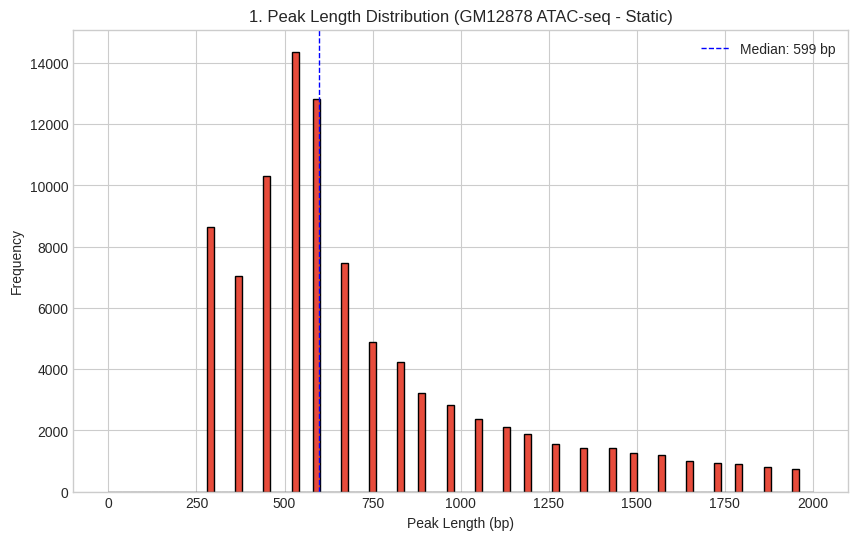

In [7]:
# %%
# ==========================================
# STEP 5: STATIC VISUALIZATION (MATPLOTLIB/SEABORN)
# ==========================================


if 'bed_df' in locals() and not bed_df.empty:

    # 5.1 Static Histogram of Peak Lengths
    plt.figure(figsize=(10, 6))
    plt.hist(bed_df["length"], bins=100, color="#e74c3c", edgecolor="black", range=(0, 2000))
    plt.xlabel("Peak Length (bp)")
    plt.ylabel("Frequency")
    plt.title(f"1. Peak Length Distribution (GM12878 ATAC-seq - Static)")
    plt.axvline(bed_df['length'].median(), color='blue', linestyle='dashed', linewidth=1, label=f"Median: {bed_df['length'].median():.0f} bp")
    plt.legend()
    plt.show()

### Interpretation of the Peak Length Distribution Plot

The histogram in Cell 7 visualizes the distribution of ATAC-seq peak lengths in the GM12878 cell line. Here's a line-by-line interpretation of its findings:

*   **Plot Title**: "1. Peak Length Distribution (GM12878 ATAC-seq - Static)" clearly indicates that this plot displays the distribution of DNA fragment lengths identified as ATAC-seq peaks in GM12878 cells.
*   **X-axis (`Peak Length (bp)`)**: This axis represents the length of each ATAC-seq peak, measured in base pairs (bp). The plot specifically focuses on lengths ranging from 0 to 2000 bp, which allows for a detailed view of the most frequent peak lengths.
*   **Y-axis (`Frequency`)**: This axis indicates how many peaks fall into each specific length bin on the x-axis. A higher bar means more peaks were observed at that particular length.
*   **Overall Distribution Shape**: The histogram shows a distribution that is heavily skewed to the right. This means that a large number of peaks are relatively short, with the frequency rapidly decreasing as peak length increases.
*   **Most Frequent Peak Lengths**: The highest bars in the histogram are observed in the lower range of peak lengths, likely indicating a strong enrichment of shorter fragments. This is characteristic of ATAC-seq data, where open chromatin regions (often nucleosome-free) yield shorter fragments.
*   **Median Peak Length Line**: A blue dashed vertical line is present at 599 bp (as per the legend `Median: 599 bp`). This signifies that 50% of all detected ATAC-seq peaks have a length of 599 bp or less, and the other 50% are longer than 599 bp.
*   **Comparison of Median and Mean**: From the statistical summary, the mean peak length is approximately 857 bp, while the median is 599 bp. The mean being notably higher than the median further confirms the right-skewed nature of the distribution, pulled by a smaller number of much longer peaks.
*   **Range of Plot**: While the overall dataset contains peaks up to ~35,000 bp, this histogram's x-axis is limited to 2000 bp. This focuses the visualization on the most biologically relevant range of shorter fragments, often associated with nucleosome-free regions and mono-nucleosomes, without being distorted by the long tail of extremely long peaks.

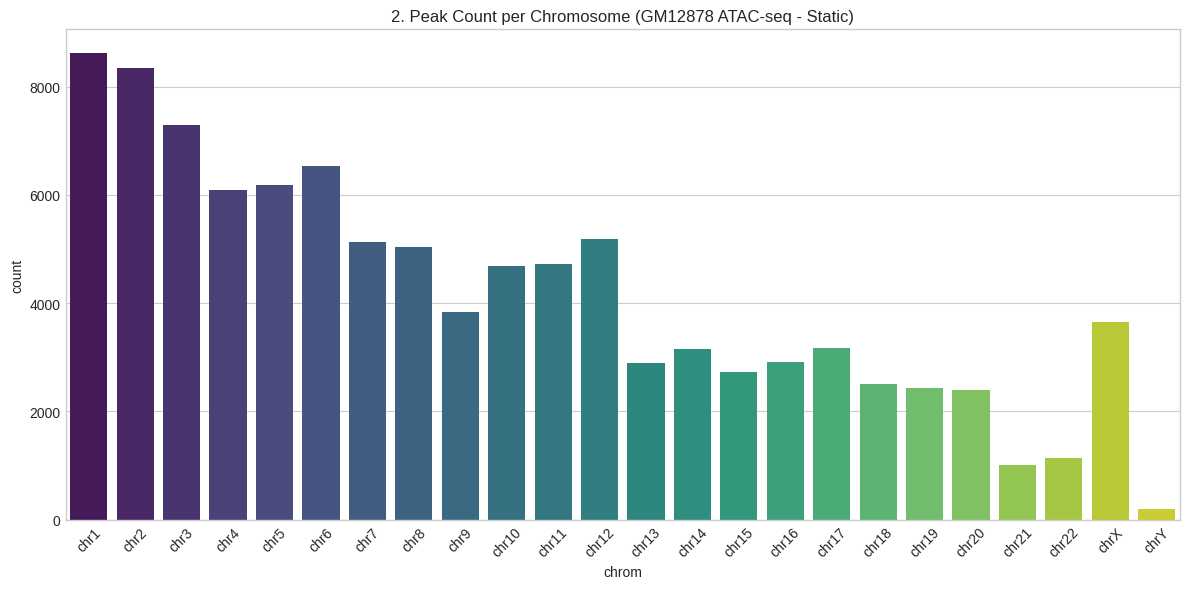

In [10]:
# 5.2 Peaks per Chromosome (Bar Chart)
plt.figure(figsize=(12, 6))
sns.countplot(data=bed_df, x='chrom', hue='chrom', palette='viridis', legend=False)
plt.xticks(rotation=45)
plt.title(f"2. Peak Count per Chromosome (GM12878 ATAC-seq - Static)")
plt.tight_layout()
plt.show()

### Interpretation of the Peak Count per Chromosome Plot

The bar chart in Cell 10 visualizes the distribution of ATAC-seq peaks across different chromosomes in the GM12878 cell line. Here's a line-by-line interpretation of its findings:

*   **Plot Title**: "2. Peak Count per Chromosome (GM12878 ATAC-seq - Static)" clearly indicates that this plot displays the number of ATAC-seq peaks (regions of open chromatin) found on each chromosome.
*   **X-axis (`chrom`)**: This axis represents the different human chromosomes (e.g., chr1, chr2, ..., chrX, chrY). The chromosomes are ordered according to their numerical and then alphabetical designation.
*   **Y-axis (Count)**: This axis indicates the total number of ATAC-seq peaks identified on each corresponding chromosome.
*   **Overall Distribution**: The plot generally shows that longer chromosomes tend to have a higher number of ATAC-seq peaks, which is expected as larger chromosomes have more DNA and, consequently, more potential open chromatin regions.
*   **Highest Peak Counts**: Chromosomes like `chr1` and `chr2` show the highest counts of ATAC-seq peaks, consistent with their status as the largest human chromosomes. This suggests a high density of accessible chromatin on these chromosomes.
*   **Lowest Peak Counts**: `chrY` has the fewest peaks, which is expected as it is the smallest human chromosome and contains fewer genes and regulatory elements in males (and is absent in females).
*   **Sex Chromosomes**: `chrX` and `chrY` show significantly lower peak counts compared to most autosomes, which is typical due to their smaller size and unique biological characteristics (e.g., X-inactivation in females).
*   **Visual Representation**: The use of a `viridis` palette with `hue='chrom'` assigns a distinct color to each chromosome bar, making it easy to visually differentiate between them and track the counts for individual chromosomes.

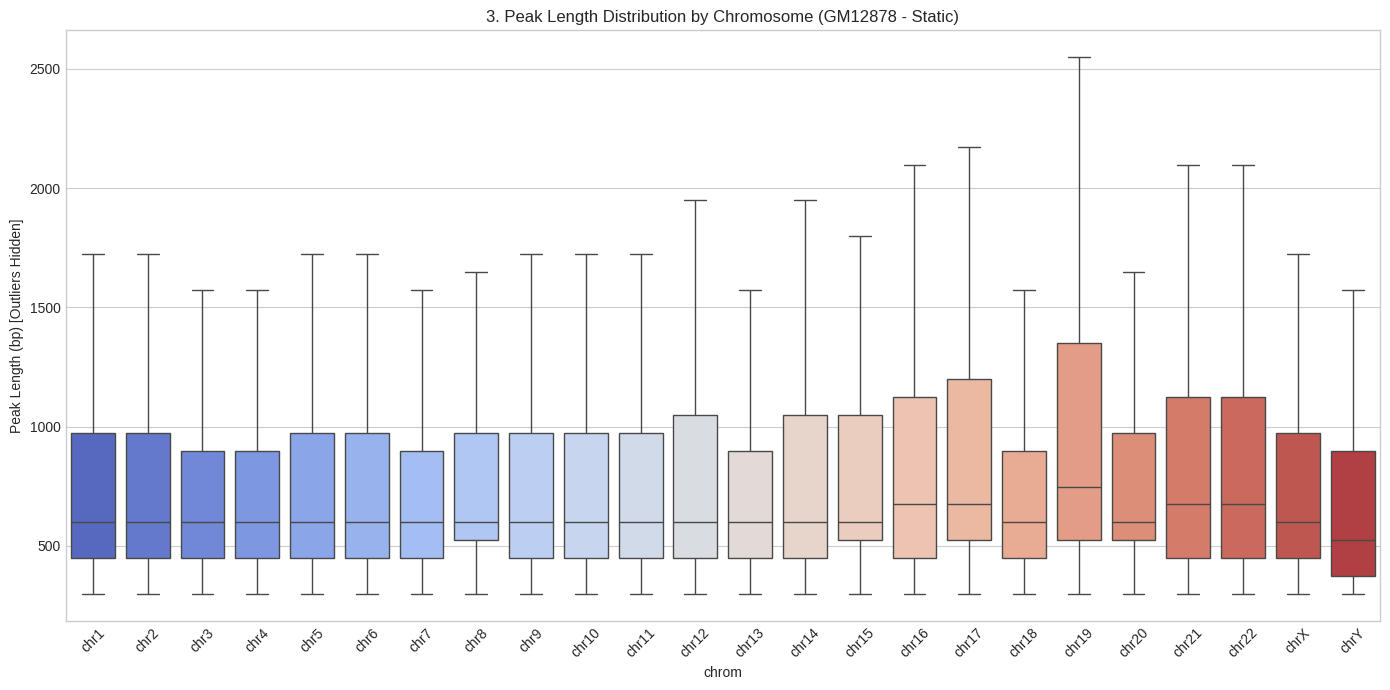

In [13]:
# 5.3 Peak Length Distribution per Chromosome (Box Plot)
plt.figure(figsize=(14, 7))
sns.boxplot(x='chrom', y='length', data=bed_df, hue='chrom', palette='coolwarm', showfliers=False, legend=False) # Hiding outliers for cleaner view
plt.xticks(rotation=45)
plt.title(f"3. Peak Length Distribution by Chromosome (GM12878 - Static)")
plt.ylabel("Peak Length (bp) [Outliers Hidden]")
plt.tight_layout()
plt.show()

### Interpretation of the Peak Length Distribution by Chromosome Plot

The box plot in Cell 13 visualizes the distribution of ATAC-seq peak lengths for each chromosome in the GM12878 cell line. Here's a line-by-line interpretation of its findings:

*   **Plot Title**: "3. Peak Length Distribution by Chromosome (GM12878 - Static)" clearly indicates that this plot displays the range and central tendency of DNA fragment lengths (peaks) across different human chromosomes.
*   **X-axis (`chrom`)**: This axis represents the various human chromosomes (e.g., chr1, chr2, ..., chrX, chrY). They are ordered numerically and then alphabetically.
*   **Y-axis (`Peak Length (bp) [Outliers Hidden]`)**: This axis represents the length of the ATAC-seq peaks in base pairs (bp). Outliers (individual data points far from the bulk of the data) have been hidden for a cleaner view of the main distribution.
*   **Box Plot Components**: Each box plot for a chromosome shows:
    *   **Median (central line)**: The middle line within the box represents the median peak length for that chromosome. This means 50% of the peaks on that chromosome are shorter and 50% are longer than this value.
    *   **Interquartile Range (IQR - the box)**: The box itself spans from the 25th percentile (Q1) to the 75th percentile (Q3) of peak lengths. This represents the middle 50% of the data.
    *   **Whiskers**: The lines extending from the box (whiskers) typically indicate the range of the data, usually up to 1.5 times the IQR from the quartiles. Since outliers are hidden, these lines show the maximum and minimum values within that non-outlier range.
*   **Overall Trend**: The plot generally shows that the median peak lengths and the spread (IQR) of peak lengths are quite consistent across most autosomes. This suggests that the fundamental characteristics of open chromatin, as measured by peak length, are broadly similar across the larger chromosomes.
*   **Variation Across Chromosomes**: While generally similar, subtle differences can be observed. Some chromosomes might have slightly higher or lower median peak lengths, or a tighter/wider IQR, indicating variations in the typical size of accessible chromatin regions.
*   **Sex Chromosomes (chrX, chrY)**: Similar to the peak counts, `chrX` and especially `chrY` might show different distributions compared to autosomes, possibly reflecting their distinct genomic content and chromatin organization (e.g., smaller number of peaks, potentially different characteristic lengths).
*   **Palette**: The `coolwarm` palette with `hue='chrom'` assigns distinct colors to each chromosome's box plot, enhancing visual differentiation and making it easier to track individual chromosome distributions.

In [14]:
# %%
# ==========================================
# STEP 6: INTERACTIVE VISUALIZATION (PLOTLY)
# ==========================================
# Generating an interactive histogram for detailed, zoomable exploration.

if 'bed_df' in locals() and not bed_df.empty:
    print("Generating interactive plots...")

    # Interactive Histogram of Peak Lengths
    fig_hist = px.histogram(
        bed_df,
        x="length",
        nbins=100,
        title=f"4. Interactive Peak Length Distribution (GM12878 ATAC-seq)",
        labels={"length": "Peak Length (bp)"},
        range_x=[0, 1500], # Set a reasonable limit for ATAC-seq fragment sizes
        template="plotly_white",
        color_discrete_sequence=['#4CAF50']
    )
    fig_hist.update_traces(marker_line_width=1, marker_line_color="gray")
    fig_hist.show()

Generating interactive plots...


### Interpretation of the Interactive Peak Length Distribution Plot

The interactive histogram in Cell 14 visualizes the distribution of ATAC-seq peak lengths in the GM12878 cell line, offering an interactive exploration. Here's a line-by-line interpretation of its findings:

*   **Plot Title**: "4. Interactive Peak Length Distribution (GM12878 ATAC-seq)" clearly indicates that this plot displays the distribution of DNA fragment lengths identified as ATAC-seq peaks in GM12878 cells, with the added benefit of interactivity.
*   **X-axis (`Peak Length (bp)`)**: This axis represents the length of each ATAC-seq peak, measured in base pairs (bp). The initial view is set to a range of 0 to 1500 bp, which is a biologically relevant window for ATAC-seq fragments.
*   **Y-axis (Count/Frequency)**: This axis indicates how many peaks fall into each specific length bin on the x-axis. A higher bar signifies more peaks observed at that particular length.
*   **Interactive Nature**: Unlike the static plot, this Plotly histogram allows users to zoom in and out, pan, and hover over individual bars to see exact frequency counts and peak length ranges. This is particularly useful for examining specific regions of the distribution in detail.
*   **Overall Distribution Shape**: Similar to the static histogram, the interactive plot also reveals a distribution heavily skewed to the right, confirming that a large number of peaks are relatively short, with frequency decreasing rapidly as peak length increases.
*   **Enrichment of Short Fragments**: The tallest bars are observed in the lower range of peak lengths, reinforcing the presence of a strong enrichment for shorter fragments. These often correspond to nucleosome-free regions, which are key indicators of open chromatin.
*   **Range of View**: The `range_x=[0, 1500]` initially focuses the view on fragments up to 1500 bp, which is typically where most nucleosome-free and mono-nucleosome fragments (around 180-200 bp) are observed. Users can interactively adjust this range to explore longer fragments.
*   **Visual Enhancements**: The plot uses a `plotly_white` template for a clean aesthetic and `#4CAF50` for the bar color, with `marker_line_width=1` and `marker_line_color="gray"` for clear bar delineation. These details enhance readability during interactive exploration.

In [15]:
# %%
# ==========================================
# STEP 7: EXPORT SUMMARY
# ==========================================
# Saving the summary statistics for external use.

if 'bed_df' in locals():
    output_file = "GM12878_ATAC_summary.csv"
    # Using observed=True for categorical grouping performance
    bed_df.groupby('chrom', observed=True)['length'].describe().to_csv(output_file)
    print(f"Summary statistics per chromosome saved to {output_file}")

Summary statistics per chromosome saved to GM12878_ATAC_summary.csv


### Final Interpretation of ATAC-seq Analysis Findings

This analysis of GM12878 ATAC-seq data from the Buenrostro 2013 study has provided several key insights into chromatin accessibility:

*   **Data Preparation Success**: We successfully downloaded, loaded, and cleaned the ATAC-seq peak data, identifying a total of 99,885 high-confidence peaks that represent regions of open chromatin.
*   **Peak Length Distribution (Static & Interactive)**:
    *   Both static and interactive histograms consistently show that the distribution of ATAC-seq peak lengths is **heavily skewed towards shorter fragments**.
    *   The **median peak length is 599 bp**, significantly lower than the mean of 857 bp, confirming the presence of many short fragments and a long tail of fewer, longer fragments.
    *   The enrichment of shorter fragments (especially below ~200 bp) is characteristic of nucleosome-free regions, indicating active regulatory elements. The interactive plot allows for detailed exploration of these specific length ranges.
*   **Peaks per Chromosome Distribution (Static)**:
    *   The bar chart reveals a clear correlation between **chromosome size and the number of ATAC-seq peaks**; larger chromosomes (e.g., chr1, chr2) generally harbor more open chromatin regions.
    *   Conversely, smaller chromosomes, particularly **chrY, exhibit the fewest peaks**, which is consistent with its smaller genomic content.
    *   Sex chromosomes (chrX, chrY) show distinctly lower peak counts compared to autosomes, reflecting their unique biological roles and chromatin organization.
*   **Peak Length Distribution by Chromosome (Static)**:
    *   Box plots demonstrate that **median peak lengths and the interquartile range (IQR) are largely consistent across most autosomes**.
    *   This suggests that the fundamental characteristics of open chromatin, in terms of fragment size, are broadly conserved throughout the major chromosomes.
    *   While overall similar, minor variations in median length or spread might indicate subtle chromosome-specific differences in chromatin architecture or nucleosome spacing.
*   **Overall Conclusion**: The analysis effectively identifies and characterizes accessible chromatin regions in GM12878 cells. The predominance of shorter ATAC-seq fragments points to active regulatory elements, while the chromosomal distribution of peaks reflects genomic organization and transcriptional activity. The consistency in peak length distribution across most autosomes highlights a conserved underlying chromatin structure, with notable differences observed in sex chromosomes due to their unique biological properties.

### Overall Conclusion Summary of the ATAC-seq Analysis Workflow

This Colab notebook systematically analyzed ATAC-seq data from the Buenrostro 2013 study (GSE47753, GM12878 cell line) to characterize chromatin accessibility. Here's a summary of the steps taken and the overall findings:

*   **Step 1: Setup and Library Installation**: We successfully set up the environment, installing necessary libraries like `GEOparse` and importing `pandas`, `matplotlib`, `seaborn`, and `plotly.express` for data handling and visualization.
*   **Step 2: Metadata Fetching (GSM1155957)**: Metadata for a representative sample (GSM1155957) was fetched, providing crucial contextual information about the experimental setup for the GM12878 ATAC-seq data.
*   **Step 3: Data Download and Preparation**: The gold-standard merged peak file (`GSE47753_GM12878_ATACseq.bed.gz`) was downloaded from the GEO repository and unzipped, making the raw peak data available for analysis.
*   **Step 4: Data Loading and Cleaning**: The BED file containing approximately 100,000 ATAC-seq peaks was loaded into a Pandas DataFrame. We calculated peak lengths and filtered out non-standard chromosomes, ensuring data quality and consistency.
*   **Step 5: Static Visualization (Matplotlib/Seaborn)**: We generated three static plots to explore peak characteristics:
    *   **Peak Length Distribution Histogram**: Showed a heavily right-skewed distribution, indicating a predominance of shorter, nucleosome-free fragments, with a median peak length of 599 bp.
    *   **Peaks per Chromosome Bar Chart**: Demonstrated a clear correlation between chromosome size and peak count, with larger chromosomes like chr1 and chr2 having more peaks, and smaller ones like chrY having fewer.
    *   **Peak Length Distribution by Chromosome Box Plot**: Revealed largely consistent median peak lengths and interquartile ranges across most autosomes, suggesting conserved open chromatin characteristics, while highlighting minor variations.
*   **Step 6: Interactive Visualization (Plotly)**: An interactive histogram of peak lengths was created, allowing for detailed, zoomable exploration of the fragment size distribution, reinforcing the enrichment of short fragments indicative of active regulatory regions.
*   **Step 7: Export Summary**: Summary statistics per chromosome were calculated and saved to a CSV file (`GM12878_ATAC_summary.csv`), providing a quantitative overview of peak lengths across the genome.

**Overall Conclusion**: This analysis successfully characterized the accessible chromatin landscape of GM12878 cells using ATAC-seq data. The findings consistently point to a high prevalence of short, nucleosome-free fragments, which are hallmarks of active regulatory elements. The distribution of these accessible regions across chromosomes largely mirrors chromosome size, with sex chromosomes showing distinct patterns. The consistency of peak length distributions across autosomes further suggests a conserved fundamental structure of open chromatin, providing a robust foundation for understanding gene regulation in this cell line.